In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import array

In [2]:
def preprocessdataframe (df):
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer = imputer.fit(df.loc[:,['Age']])
    df.loc[:,'Age'] = imputer.transform(df.loc[:,['Age']])

    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer = imputer.fit(df.loc[:,['Fare']])
    df.loc[:,'Fare'] = imputer.transform(df.loc[:,['Fare']])

    df.Embarked = df.Embarked.fillna('S')

    df = pd.get_dummies(data=df, columns=['Embarked', 'Pclass', 'Sex'])

    return df


In [3]:
def showdecisiontree(model, feature_names, name):
    dot_data = tree.export_graphviz(model, out_file=None,
         feature_names=feature_names,
         class_names=['Did not survive', 'Survived'],
         filled=True, rounded=True,
         special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(name)
    return True

In [4]:
def showroccurve(fpr, tpr, roc_auc, label):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve - {0} (area = {1:0.2f})'.format(label, roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def showmultiroccurve(params): #this should be a list of dictionaries of fpr, tpr, roc_auc, and label
    plt.figure()
    lw = 2
    for param in params:
        plt.plot(param["fpr"], param["tpr"], color='darkorange',
             lw=lw, label='ROC curve - {0} (area = {1:0.2f})'.format(param["label"],param["roc_auc"]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
df = pd.read_csv('~/Documents/GitHub/TiberDataScienceLearning/Data/Titanic/train.csv')
y = df[['Survived']]
x = df[['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]


In [7]:
#split off 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
x_train = preprocessdataframe(x_train)
x_test = preprocessdataframe(x_test)


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [8]:

clf = tree.DecisionTreeClassifier()
model = clf.fit(x_train, y_train)


In [9]:
y_predictions = model.predict(x_test)
y_predictions_proba = model.predict_proba(x_test)


In [10]:
cm = pd.DataFrame(
    confusion_matrix(y_test, y_predictions),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival']
)

score = model.score(x_test, y_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predictions)
roc_auc = metrics.roc_auc_score(y_test, y_predictions)
label = 'No Hyperparameters'
roc_auc

0.7442687747035573

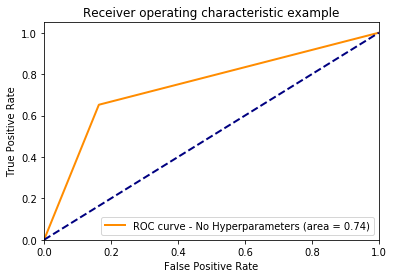

In [11]:
showroccurve(fpr, tpr, roc_auc, label)


In [18]:
seed = 42
np.random.seed(seed)

clf = tree.DecisionTreeClassifier()

cross_val_roc = cross_val_score(clf, X=x_train, y=y_train, cv=10, scoring='roc_auc')
cross_val_mean_roc_score = np.mean(cross_val_roc)
cross_val_mean_roc_score # = 0.7603877926552346


0.7542171087955972

In [19]:
fprs = []
tprs = []
rocs = []

clfkfold = tree.DecisionTreeClassifier()
kf = KFold(n_splits=10, random_state=seed)

In [20]:
for train_index, test_index in kf.split(x_train):
    clfkfold = tree.DecisionTreeClassifier()

    cvv_x_train, cvv_x_test = x_train.iloc[train_index], x_train.iloc[test_index]
    cvv_y_train, cvv_y_test = y_train.iloc[train_index], y_train.iloc[test_index]


    clfkfold = clfkfold.fit(cvv_x_train, cvv_y_train)
    cvv_y_predictions = clfkfold.predict(cvv_x_test)

    cvv_cm = pd.DataFrame(
        confusion_matrix(cvv_y_test, cvv_y_predictions),
        columns=['Predicted Not Survival', 'Predicted Survival'],
        index=['True Not Survival', 'True Survival']
    )
    cvv_score = clfkfold.score(cvv_x_test, cvv_y_test)

    cvv_fpr, cvv_tpr, thresholds = metrics.roc_curve(cvv_y_test, cvv_y_predictions)
    cvv_roc_auc = metrics.roc_auc_score(cvv_y_test, cvv_y_predictions)

    fprs.append(cvv_fpr[1])
    tprs.append(cvv_tpr[1])
    rocs.append(cvv_roc_auc)


In [21]:

avgfpr = array.array('f', [0.0, np.mean(fprs), 1])
avgtpr = array.array('f', [0.0, np.mean(tprs), 1])
avgroc = np.mean(rocs)
avgroc 

0.7339368420824088

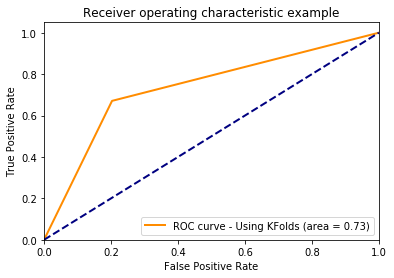

In [22]:
label = "Using KFolds"
showroccurve(avgfpr, avgtpr, avgroc, label)